# Simple Least Cost Path Analysis

## 1. Create a grid using numpy array

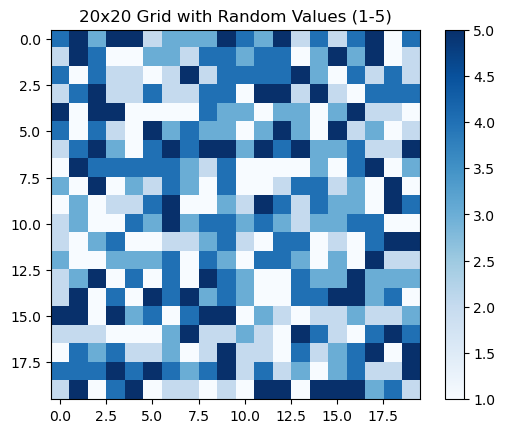

In [1]:
import numpy as np

# create a grid (all zeros)
grid_size = (20, 20)
grid = np.zeros(grid_size, dtype=float)

# optional: create coordinate matrices if you need indices for each cell
x = np.arange(grid_size[1])
y = np.arange(grid_size[0])
X, Y = np.meshgrid(x, y)

# assign a random value (1-5, int) to each cell <-- 'cost values'
# set random seed for reproducibility
np.random.seed(42)
grid = np.random.randint(1, 6, size=grid_size)

# Visualize the grid using matplotlib
import matplotlib.pyplot as plt
plt.imshow(grid, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title(f'{grid_size[0]}x{grid_size[1]} Grid with Random Values (1-5)')
plt.show()

## 2. Randomly assign start and destination cells

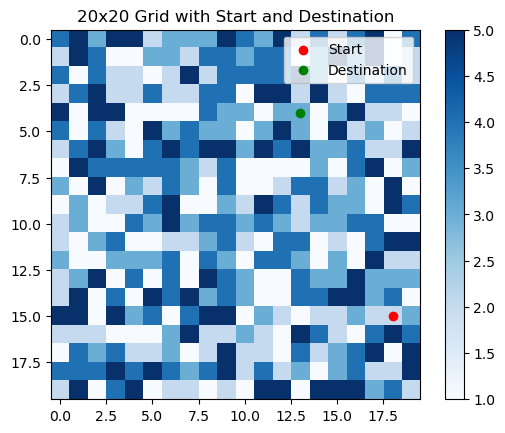

In [2]:
# Randomly assign start and destination cells
start = (np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1]))
destination = (np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1]))

# Ensure start and destination are not the same
while start == destination:
    destination = (np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1]))

# Visualize start and destination on the grid
im = plt.imshow(grid, cmap='Blues', interpolation='nearest')
plt.scatter(*start[::-1], color='red', label='Start')
plt.scatter(*destination[::-1], color='green', label='Destination')
plt.colorbar(im)  # Pass the image to colorbar
plt.title(f'{grid_size[0]}x{grid_size[1]} Grid with Start and Destination')
plt.legend()
plt.show()

## 3. Find the least cost path between start and destination

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

# Convert the grid to a graph
def grid_to_graph(grid) -> csr_matrix:
    """
    Convert a 2D cost grid into a sparse adjacency graph (CSR matrix).

    Each grid cell becomes a node. Edges connect 4-neighbors (up, down, left, right).
    The weight of an edge from cell A to neighbor B is the cost of entering B
    (i.e., the value stored in the neighbor cell).

    Parameters
    ----------
    grid : numpy.ndarray
        2D array of non-negative costs (shape: rows x cols).

    Returns
    -------
    scipy.sparse.csr_matrix
        Sparse adjacency matrix of shape (n, n) where n = rows * cols.
        Entry (i, j) is nonzero if node i has an edge to node j, and its value
        is the cost to move from i into j.
    """
    rows, cols = grid.shape
    n = rows * cols
    data = []
    row_ind = []
    col_ind = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1),
                           (-1, -1), (-1, 1), (1, -1), (1, 1)]:  # 8 neighbors
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    nidx = nr * cols + nc
                    data.append(grid[nr, nc])
                    row_ind.append(idx)
                    col_ind.append(nidx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(n, n), dtype=grid.dtype)

graph = grid_to_graph(grid)
# print numbers of nodes and edges
print(f'Graph has {graph.shape[0]} nodes and {graph.nnz} edges')

Graph has 400 nodes and 2964 edges


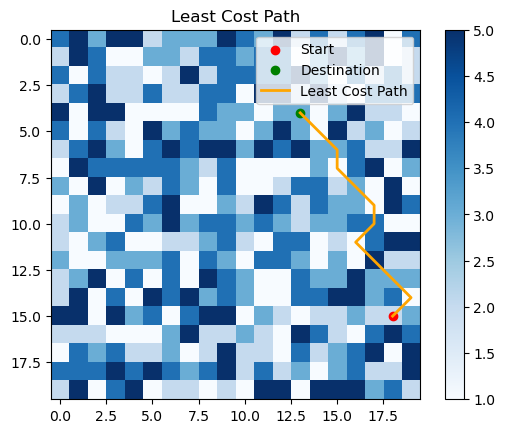

([(15, 18),
  (14, 19),
  (13, 18),
  (12, 17),
  (11, 16),
  (10, 17),
  (9, 17),
  (8, 16),
  (7, 15),
  (6, 15),
  (5, 14),
  (4, 13)],
 13.0)

In [4]:
def least_cost_path(grid, start, destination, plot=True, cmap='Blues'):
    """
    Find least-cost path on a 2D cost grid from start to destination using Dijkstra
    (scipy.sparse.csgraph.shortest_path). Returns (path, total_cost).
    - grid: 2D numpy array of non-negative costs (cost to enter a cell).
    - start, destination: (row, col) tuples.
    - plot: if True, draws the grid and the path using matplotlib.
    """
    rows, cols = grid.shape
    assert 0 <= start[0] < rows and 0 <= start[1] < cols, "start out of bounds"
    assert 0 <= destination[0] < rows and 0 <= destination[1] < cols, "destination out of bounds"

    graph = grid_to_graph(grid)
    start_idx = start[0] * cols + start[1]
    dest_idx = destination[0] * cols + destination[1]

    dist_matrix, predecessors = shortest_path(graph, directed=False, indices=start_idx, return_predecessors=True)

    path = None
    total_cost = np.inf
    if np.isfinite(dist_matrix[dest_idx]):
        # reconstruct path from destination back to start using predecessors
        path = []
        i = dest_idx
        while i != start_idx:
            path.append((i // cols, i % cols))
            i = int(predecessors[i])
        path.append(start)
        path = path[::-1]
        total_cost = float(dist_matrix[dest_idx])

    if plot:
        im = plt.imshow(grid, cmap=cmap, interpolation='nearest')
        plt.scatter(*start[::-1], color='red', label='Start')
        plt.scatter(*destination[::-1], color='green', label='Destination')
        if path:
            y, x = zip(*path)
            plt.plot(x, y, color='orange', linewidth=2, label='Least Cost Path')
        plt.colorbar(im)
        plt.title('Least Cost Path')
        plt.legend()
        plt.show()

    return path, total_cost

least_cost_path(grid, start, destination)

## Note: Sparse Matrix

In [5]:
from scipy.sparse import csr_matrix
dense = [[0, 0, 3],
         [4, 0, 0],
         [0, 0, 0]]
sparse = csr_matrix(dense)
print(sparse)

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 2 stored elements and shape (3, 3)>
  Coords	Values
  (0, 2)	3
  (1, 0)	4


# Add elevation cost

Data source: [Earth Explorer USGS](https://earthexplorer.usgs.gov/)
1996-12-01


## 1. Load GeoTIF data

Loaded: geodata\gt30w100n40.tif
Shape: (6000, 4800)
CRS: EPSG:4326
Bounds: BoundingBox(left=-100.0, bottom=-9.999999999980012, right=-60.000000000015994, top=39.99999999999999)
Metadata keys: ['driver', 'dtype', 'nodata', 'width', 'height', 'count', 'crs', 'transform']


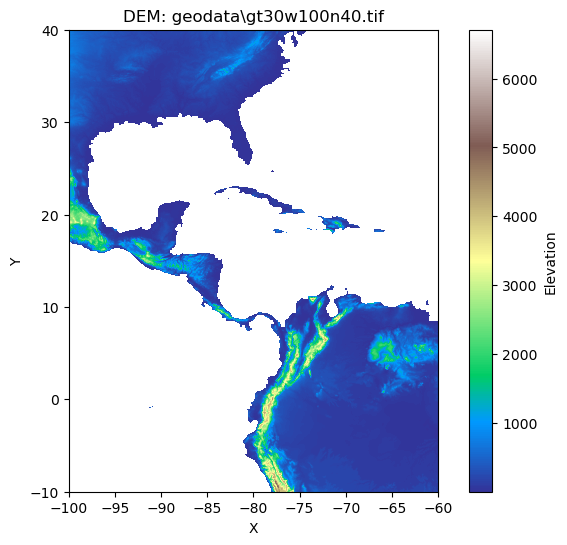

In [6]:
import rasterio
import numpy as np

# Read DEM from GeoTIFF and visualize

fp = r'geodata\gt30w100n40.tif'

with rasterio.open(fp) as src:
    # read first band as a masked array (nodata masked)
    dem = src.read(1, masked=True)
    dem_meta = src.meta.copy()
    dem_bounds = src.bounds
    dem_transform = src.transform
    dem_crs = src.crs

print("Loaded:", fp)
print("Shape:", dem.shape)
print("CRS:", dem_crs)
print("Bounds:", dem_bounds)
print("Metadata keys:", list(dem_meta.keys()))

# Quick plot (uses matplotlib imported earlier in the notebook)
plt.figure(figsize=(8, 6))
plt.imshow(dem, cmap='terrain',
           extent=(dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top),
           origin='upper')
plt.colorbar(label='Elevation')
plt.title('DEM: ' + fp)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Crop shape: (601, 601)
Bounds: left=-70.000000000012, right=-64.99166666668066, bottom=-2.0083333333165445, top=3.0000000000147864


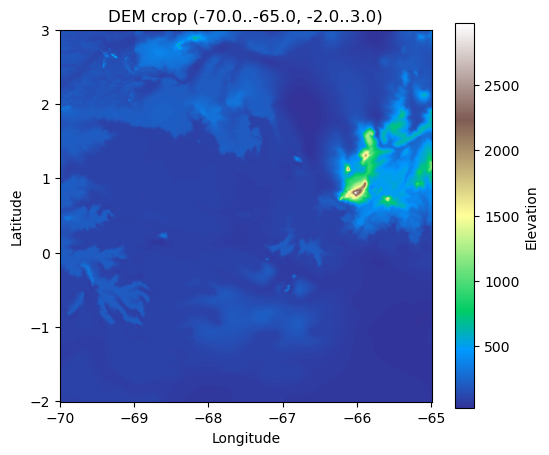

In [7]:
# Crop DEM to lon (X) from -70 to -65 and lat (Y) from -2 to 3
xmin, xmax = -70.0, -65.0
ymin, ymax = -2.0, 3.0

# compute row/col for the bounding coordinates (note rowcol expects xs, ys)
rows, cols = rasterio.transform.rowcol(dem_transform, [xmin, xmax], [ymax, ymin])
row_start, row_stop = min(rows), max(rows) + 1
col_start, col_stop = min(cols), max(cols) + 1

# clamp to DEM array bounds
row_start = max(0, row_start)
row_stop  = min(dem.shape[0], row_stop)
col_start = max(0, col_start)
col_stop  = min(dem.shape[1], col_stop)

# perform crop
dem_crop = dem[row_start:row_stop, col_start:col_stop]

if dem_crop.size == 0:
    print("Requested bbox does not intersect the DEM.")
else:
    # compute georeferenced bounds for the cropped array
    left  = dem_transform.c + col_start * dem_transform.a
    top   = dem_transform.f + row_start * dem_transform.e
    right = left + dem_crop.shape[1] * dem_transform.a
    bottom= top  + dem_crop.shape[0] * dem_transform.e

    print(f"Crop shape: {dem_crop.shape}")
    print(f"Bounds: left={left}, right={right}, bottom={bottom}, top={top}")

    # plot cropped DEM
    plt.figure(figsize=(6,5))
    plt.imshow(dem_crop, cmap='terrain',
               extent=(left, right, bottom, top),
               origin='upper')
    plt.colorbar(label='Elevation')
    plt.title(f"DEM crop ({xmin}..{xmax}, {ymin}..{ymax})")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

## 2. Create a grid using elevation data

In [8]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_origin
import numpy as np

def resample_dem_to_utm(dem, target_resolution, dem_meta=None):
    """
    Resample a (cropped) DEM numpy.ma array to a meter-based UTM CRS at the requested
    target_resolution (meters). Returns (dem_utm, dst_transform, dst_crs, X_utm, Y_utm).

    Uses notebook globals (dem_meta, dem_transform, dem_crs, left, right, top, bottom)
    when optional metadata is not provided.
    """
    # fallback to notebook globals if not provided
    dem_meta = dem_meta if dem_meta is not None else globals().get('dem_meta')
    src_crs = globals().get('dem_crs')
    left = globals().get('left')
    right = globals().get('right')
    top = globals().get('top')
    bottom = globals().get('bottom')
    src_transform_glob = globals().get('dem_transform')

    assert src_crs is not None and src_transform_glob is not None and None not in (left, right, top, bottom), \
        "Source CRS/transform and bounds must be available in notebook globals"

    src_height, src_width = dem.shape

    # build source transform for the cropped array (uses original DEM pixel size)
    src_transform = from_origin(left, top, src_transform_glob.a, abs(src_transform_glob.e))

    # choose a meter-based CRS (UTM) based on the crop centroid
    centroid_lon = (left + right) / 2.0
    centroid_lat = (top + bottom) / 2.0
    zone = int((centroid_lon + 180) / 6) + 1
    dst_epsg = 32600 + zone if centroid_lat >= 0 else 32700 + zone
    dst_crs = rasterio.crs.CRS.from_epsg(dst_epsg)

    # compute destination transform and size for the requested resolution
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs,
        src_width, src_height,
        left, bottom, right, top,
        resolution=target_resolution
    )
    dst_width = int(dst_width)
    dst_height = int(dst_height)

    # prepare source array (fill masked nodata with the nodata value from metadata)
    src_nodata = dem_meta.get('nodata', np.nan) if dem_meta is not None else np.nan
    src_array = dem.filled(src_nodata).astype(np.float32)

    # destination array (float32) with NaN as nodata
    dst = np.full((dst_height, dst_width), np.nan, dtype=np.float32)

    # reproject / resample (bilinear)
    reproject(
        source=src_array,
        src_transform=src_transform,
        src_crs=src_crs,
        destination=dst,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear,
        src_nodata=src_nodata,
        dst_nodata=np.nan
    )

    # mask invalid / nodata values
    dem_utm = np.ma.masked_invalid(dst)

    # build coordinate arrays (easting, northing) for cell centers
    x_coords = dst_transform.c + (np.arange(dst_width) + 0.5) * dst_transform.a
    y_coords = dst_transform.f + (np.arange(dst_height) + 0.5) * dst_transform.e
    X_utm, Y_utm = np.meshgrid(x_coords, y_coords)

    print("dem_utm.shape:", dem_utm.shape)
    print("dst_crs:", dst_crs)
    print("dst_transform:", dst_transform)

    return dem_utm, dst_transform, dst_crs, X_utm, Y_utm

dem_utm, dem_utm_transform, dem_utm_crs, X_utm, Y_utm = resample_dem_to_utm(dem_crop, target_resolution=500)


dem_utm.shape: (1110, 1116)
dst_crs: EPSG:32619
dst_transform: | 500.00, 0.00, 388719.35|
| 0.00,-500.00, 332410.28|
| 0.00, 0.00, 1.00|


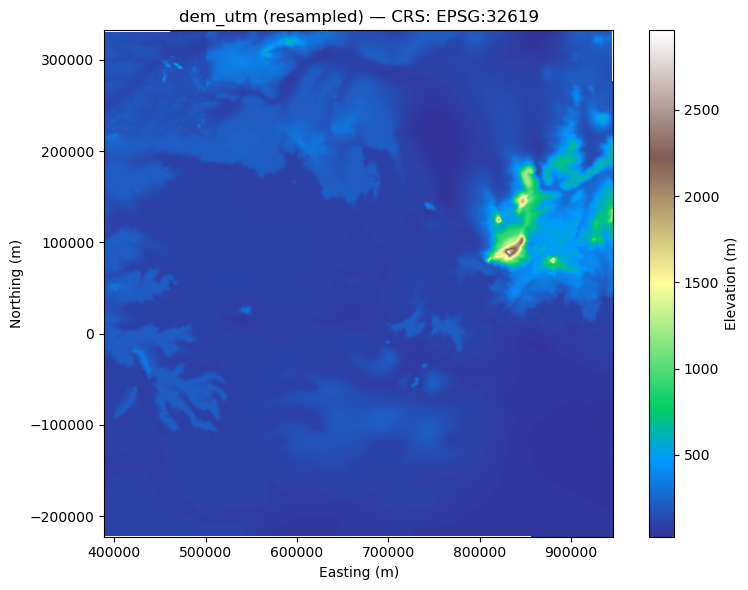

In [9]:
plt.figure(figsize=(8, 6))

# compute extent from X_utm/Y_utm (cell-center coordinates)
left, right = X_utm.min(), X_utm.max()
bottom, top = Y_utm.min(), Y_utm.max()

im = plt.imshow(dem_utm, cmap='terrain', extent=(left, right, bottom, top), origin='upper')
plt.colorbar(im, label='Elevation (m)')
plt.title(f'dem_utm (resampled) — CRS: {dem_utm_crs}')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.tight_layout()
plt.show()


## 3. Assign start and destination

start (row, col): (322, 128)
destination (row, col): (56, 744)
start UTM (E,N): (452969.3495282389, 171160.2798469091)
destination UTM (E,N): (760969.3495282389, 304160.2798469091)


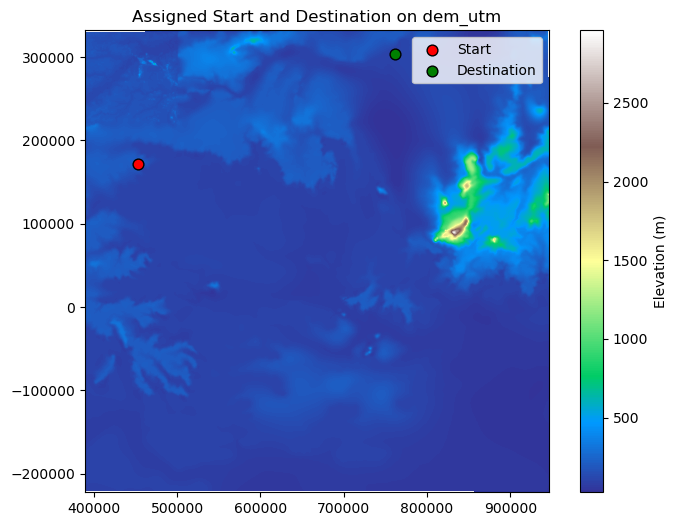

In [14]:
# Choose two distinct valid cells in dem_utm (row, col) and plot them.
mask = np.ma.getmaskarray(dem_utm)
valid = np.column_stack(np.where(~mask))

if valid.shape[0] < 2:
    raise RuntimeError("Not enough valid (unmasked) cells in dem_utm to pick start/destination.")

# np.random.seed(111)
i_start, i_dest = np.random.choice(valid.shape[0], size=2, replace=False)
start = tuple(valid[i_start])
destination = tuple(valid[i_dest])

print("start (row, col):", start)
print("destination (row, col):", destination)
print("start UTM (E,N):", (float(X_utm[start]), float(Y_utm[start])))
print("destination UTM (E,N):", (float(X_utm[destination]), float(Y_utm[destination])))

# Quick plot on dem_utm (uses existing X_utm/Y_utm for coordinates)
plt.figure(figsize=(8, 6))
left, right = X_utm.min(), X_utm.max()
bottom, top = Y_utm.min(), Y_utm.max()
im = plt.imshow(dem_utm, cmap='terrain', extent=(left, right, bottom, top), origin='upper')
plt.scatter([X_utm[start]], [Y_utm[start]], c='red', s=60, label='Start', edgecolor='k')
plt.scatter([X_utm[destination]], [Y_utm[destination]], c='green', s=60, label='Destination', edgecolor='k')
plt.colorbar(im, label='Elevation (m)')
plt.legend()
plt.title('Assigned Start and Destination on dem_utm')
plt.show()

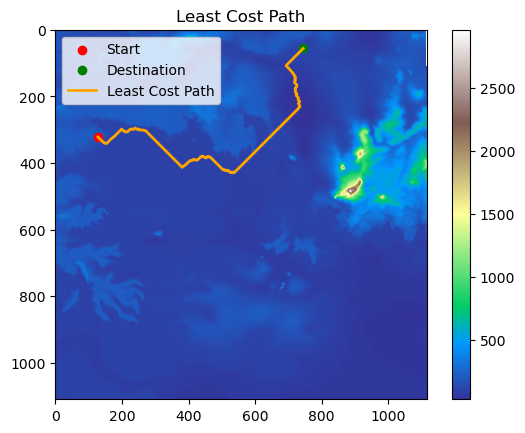

Path length (nodes): 783
Total cost: 64012.601415634155
Path (row, col): [(322, 128), (323, 129), (324, 130), (325, 131), (326, 132), (327, 133), (328, 134), (329, 135), (330, 136), (331, 137), (332, 138), (333, 139), (334, 140), (335, 141), (336, 142), (337, 143), (337, 144), (337, 145), (338, 146), (339, 147), (340, 148), (341, 149), (341, 150), (341, 151), (341, 152), (341, 153), (341, 154), (340, 155), (339, 156), (338, 157), (337, 158), (336, 159), (335, 160), (334, 161), (333, 162), (332, 163), (331, 164), (330, 165), (329, 166), (328, 167), (327, 168), (326, 169), (326, 170), (325, 171), (324, 172), (323, 173), (322, 174), (321, 175), (321, 176), (320, 177), (319, 178), (318, 179), (317, 180), (316, 181), (315, 182), (314, 183), (313, 184), (312, 185), (311, 186), (310, 187), (309, 188), (308, 189), (307, 190), (306, 191), (305, 192), (304, 193), (303, 194), (302, 195), (301, 196), (300, 197), (299, 198), (298, 199), (299, 200), (300, 201), (301, 202), (302, 203), (302, 204), (3

In [15]:
# Run least-cost path using the existing start/destination variables
path, total_cost = least_cost_path(dem_utm, start, destination, plot=True, cmap='terrain')

# Print results succinctly
if path:
    print("Path length (nodes):", len(path))
    print("Total cost:", total_cost)
    print("Path (row, col):", path)
else:
    print("No path found between", start, "and", destination)

In [17]:
# compute and print dem_crop size
rows, cols = dem_utm.shape
px = dem_utm_transform.a          # pixel width in meters (should be 500.0)
py = abs(dem_utm_transform.e)     # pixel height in meters (abs, should be 500.0)

# compute in meters (existing)
width_m = cols * px
height_m = rows * py
area_m2 = width_m * height_m

# convert to kilometers
px_km = px / 1000.0
py_km = py / 1000.0
width_km = width_m / 1000.0
height_km = height_m / 1000.0
area_km2 = area_m2 / 1e6

print(f"Crop shape: {rows} rows x {cols} cols")
print(f"Pixel size: {px_km:.3f} km x {py_km:.3f} km ({px:.0f} m x {py:.0f} m)")
print(f"Width: {width_km:,.3f} km ({width_m:,.0f} m)")
print(f"Height: {height_km:,.3f} km ({height_m:,.0f} m)")
print(f"Area: {area_km2:,.3f} km² ({area_m2:,.0f} m²)")

Crop shape: 1110 rows x 1116 cols
Pixel size: 0.500 km x 0.500 km (500 m x 500 m)
Width: 558.000 km (558,000 m)
Height: 555.000 km (555,000 m)
Area: 309,690.000 km² (309,690,000,000 m²)
